# __<u>Initialize Cloud-AI Engine</u>__ 
> with a developed and distinct environment: __py39-VPP__
>> you can use --> cmd Run: __conda install -n "env" ipykernel --update-deps --force-reinstall__

> Install/Verify Packages

In [1]:
%pip install --user --upgrade pandas
%pip install --user --upgrade "sqlalchemy<2.0"
%pip install --user --upgrade mariadb
%pip install --user --upgrade -U matplotlib
%pip install --user --upgrade seaborn
%pip install --user -U scikit-learn

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ----------------- ---------------------- 0.7/1.6 MB 22.5 MB/s eta 0:00:01
     ---------------------------------- ----- 1.4/1.6 MB 17.5 MB/s eta 0:00:01
     ---------------------------------------  1.6/1.6 MB 16.8 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 1.4.47
    Uninstalling SQLAlchemy-1.4.47:
      Successfully uninstalled SQLAlchemy-1.4.47
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


> Import Libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense
import gym
from collections import deque
import seaborn as sns
import random

# __Configure Simulation Setup__

> Define directory of Processed Data

In [3]:
loadDirectory = '../Data/ProcessedData/'

>Define directory of Trained Models

In [4]:
# Create a directory to save the models
model_save_dir = "v1.1"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

> Define colunmns and rows of pandas output

In [5]:
# pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50000)

> Work on GPU utilization
>> 1. https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
>> 2. https://www.tensorflow.org/guide/gpu#using_multiple_gpus
>> 3. https://www.tensorflow.org/guide/gpu#using_a_single_gpu_on_a_multi-gpu_system

In [6]:
### Limiting GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print('Available Physical GPUs=>'+str(gpus))
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print('Configured Logical GPUs=>'+str(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Available Physical GPUs=>[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Configured Logical GPUs=>[LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


> Define GPU which will be used

In [7]:
# Set the GPU you want to use
selectGPU = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(selectGPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
    selectedGPU = f"/device:GPU:{selectGPU}"
    print(f"Using GPU: {selectedGPU}")

### Clearing Tensorflow Session
tf.keras.backend.clear_session()

Using GPU: /device:GPU:1


# __<u>PV Data Processing for Model Development and Testing</u>__

> __<u> Load Pre-processed Power Plants data for each PV power plant </u>__
>> Note from ENS: 
>>   * Power_Plant 3, C_pcode __71780001~71780003__ : Seomyeon, Gyeongju-si, Gyeongsangbuk-do

In [8]:
PV1 = pd.read_csv(f"{loadDirectory}PV_71780001.gzip", compression="gzip")
PV2 = pd.read_csv(f"{loadDirectory}PV_71780002.gzip", compression="gzip") 
PV3 = pd.read_csv(f"{loadDirectory}PV_71780004.gzip", compression="gzip")

> <b>Dropped</b> unnecessary data, <b>renamed</b> column and <b>set index</b> with timestamp

In [9]:
PV1 = PV1.drop(columns={'day_power'}).rename(columns={'inst_power':'pv1_power'}).set_index('timestamp')
PV2 = PV2.drop(columns={'day_power'}).rename(columns={'inst_power':'pv2_power'}).set_index('timestamp')
PV3 = PV3.drop(columns={'day_power'}).rename(columns={'inst_power':'pv3_power'}).set_index('timestamp')

>Combine above dataFrames to <b>raw_data</b> according to the index and <b>calculated total power</b>

In [10]:
raw_data = PV1.join(PV2).join(PV3)
raw_data = raw_data.fillna(0)
# calculate the total power output and add it as a new column
raw_data['total_power'] = raw_data.sum(axis=1)
raw_data=raw_data.reset_index()
# Convert the 'timestamp' column to a pandas datetime object
raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])
raw_data ['timestamp'][0]

Timestamp('2020-11-10 18:20:00')

>Plot each column of <b>plot_data</b> against the timestamp

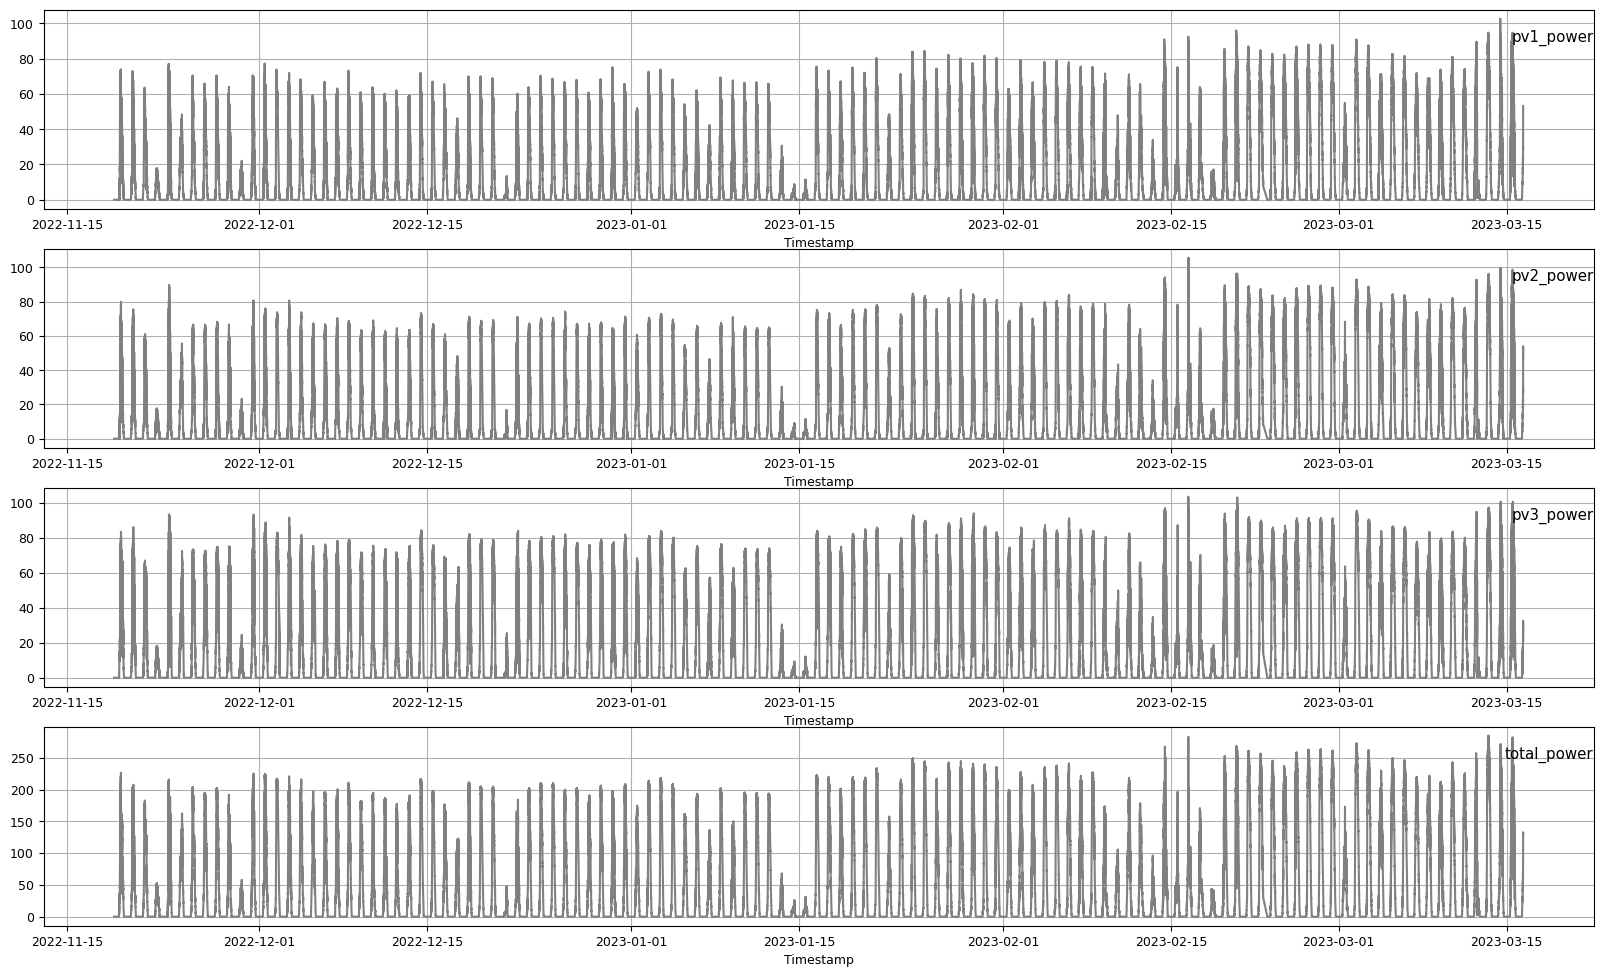

In [11]:
plot_data = raw_data[60*24*30*24:]
i    = 1
plt.figure(figsize=(20, 15))
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = '9'
for counter in range(1,len(plot_data.columns)):
    plt.subplot(len(plot_data.columns), 1, i)
    plt.plot(plot_data.values[:, 0], plot_data.values[:, counter], color = 'gray')
    # plt.plot(data.values[:, counter], color = 'gray')
    plt.title(plot_data.columns[counter], y=0.8, loc='right')
    plt.xlabel('Timestamp')
    plt.ylabel('')
    plt.grid(True)
    i = i+1
plt.show()

> <b>Segment data</b> into windows of specified length and stride

In [12]:
# input features
data = plot_data.drop(columns=['timestamp', 'total_power'])
# Convert plot_data to data_np as np arrary
data_np = np.array(data)
print(data_np)

# Define window length and stride for segmenting data
window_length = 60*24*7  # Length of the window (number of data points per segment)
stride        = 60*24*1   # Number of data points to move the window after each episode
count         = 0

# Assuming pv1_power, pv2_power, and pv3_power are the column indices for the respective columns
pv1_power	 = 0
pv2_power	 = 1
pv3_power	 = 2

# Initialize an empty list to store the segmented data
data_np_segments = []

for episode_start in range(0, len(data_np), stride):
    episode_end = episode_start + window_length
    print(f'count={count}||episode_start={episode_start}||episode_end={episode_end}')
    
    # Slice the train_data array to get the specified columns for the current segment
    data_segment = data_np[episode_start:episode_end, [pv1_power, pv2_power, pv3_power]]
    
    # Append the segment to the list
    data_np_segments.append(data_segment)
    
    count += 1

[[ 0.   0.   0. ]
 [ 0.   0.   0. ]
 [ 0.   0.   0. ]
 ...
 [44.3 48.6 32.6]
 [50.8 54.  28. ]
 [53.1 46.7 28.3]]
count=0||episode_start=0||episode_end=10080
count=1||episode_start=1440||episode_end=11520
count=2||episode_start=2880||episode_end=12960
count=3||episode_start=4320||episode_end=14400
count=4||episode_start=5760||episode_end=15840
count=5||episode_start=7200||episode_end=17280
count=6||episode_start=8640||episode_end=18720
count=7||episode_start=10080||episode_end=20160
count=8||episode_start=11520||episode_end=21600
count=9||episode_start=12960||episode_end=23040
count=10||episode_start=14400||episode_end=24480
count=11||episode_start=15840||episode_end=25920
count=12||episode_start=17280||episode_end=27360
count=13||episode_start=18720||episode_end=28800
count=14||episode_start=20160||episode_end=30240
count=15||episode_start=21600||episode_end=31680
count=16||episode_start=23040||episode_end=33120
count=17||episode_start=24480||episode_end=34560
count=18||episode_start=

> Test_point

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


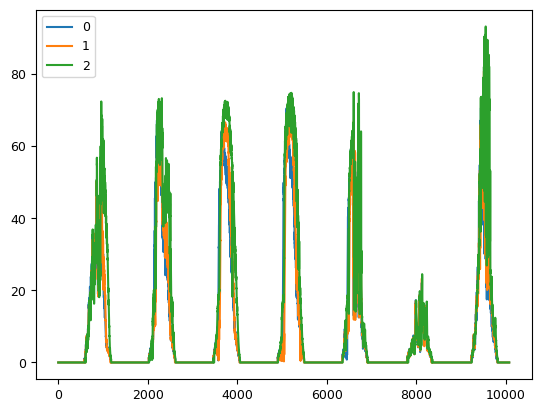

In [13]:
print(data_np_segments[5])
pd.DataFrame(data_np_segments[5]).plot()
plt.show()

# __<u>DDPG-based Stochastic Optimal Power Flow Analysis of VPP</u>__

In [14]:
class DDPG:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, tau):
        self.state_dim        = state_dim
        self.action_dim       = action_dim
        self.lr_actor         = lr_actor
        self.lr_critic        = lr_critic
        self.gamma            = gamma
        self.tau              = tau
        self.actor            = self.build_actor()
        self.target_actor     = self.build_actor()
        self.critic           = self.build_critic()
        self.target_critic    = self.build_critic()
        self.actor_optimizer  = tf.keras.optimizers.Adam(lr_actor)
        self.critic_optimizer = tf.keras.optimizers.Adam(lr_critic)

    def build_actor(self):
        model = tf.keras.Sequential([
            Dense(64, activation='relu', input_shape=(self.state_dim,)),
            Dense(64, activation='relu'),
            Dense(self.action_dim, activation='tanh')
        ])
        return model

    def build_critic(self):
        state_input  = tf.keras.Input(shape=(self.state_dim,))
        action_input = tf.keras.Input(shape=(self.action_dim,))
        state_net    = Dense(64, activation='relu')(state_input)
        action_net   = Dense(64, activation='relu')(action_input)
        net          = tf.keras.layers.Concatenate()([state_net, action_net])
        net          = Dense(64, activation='relu')(net)
        net          = Dense(1)(net)
        model        = tf.keras.Model(inputs=[state_input, action_input], outputs=net)
        return model
    
    def update_target_networks(self):
        actor_weights         = self.actor.get_weights()
        target_actor_weights  = self.target_actor.get_weights()
        critic_weights        = self.critic.get_weights()
        target_critic_weights = self.target_critic.get_weights()

        for i in range(len(actor_weights)):
            target_actor_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * target_actor_weights[i]

        for i in range(len(critic_weights)):
            target_critic_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * target_critic_weights[i]

        self.target_actor.set_weights(target_actor_weights)
        self.target_critic.set_weights(target_critic_weights)

    def train(self, replay_buffer, batch_size):
        with tf.device(selectedGPU):  # Add this line to ensure operations are performed on the specified GPU

            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

            # Update critic
            target_actions = self.target_actor(next_states)
            target_q_values = self.target_critic([next_states, target_actions])
            target_q_values = rewards + (1 - dones) * self.gamma * target_q_values
            with tf.GradientTape() as tape:
                q_values = self.critic([states, actions])
                critic_loss = tf.reduce_mean(tf.square(target_q_values - q_values))
            critic_grad = tape.gradient(critic_loss, self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic.trainable_variables))

            # Update actor
            with tf.GradientTape() as tape:
                actions = self.actor(states)
                actor_loss = -tf.reduce_mean(self.critic([states, actions]))
            actor_grad = tape.gradient(actor_loss, self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor.trainable_variables))

            # Update target networks
            self.update_target_networks()

    def load_weights(self, actor_weights_path, critic_weights_path):
        self.actor.load_weights(actor_weights_path)
        self.critic.load_weights(critic_weights_path)

In [15]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return [np.array(x) for x in zip(*batch)]

    def __len__(self):
        return len(self.buffer)

In [16]:
class VPPEnvironment(gym.Env):
    def __init__(self, data: pd.DataFrame, ess_charging_efficiency=0.95, ess_discharging_efficiency=0.95, demand_uncertainty_factor=0.01, demand_deviation_threshold=5, consecutive_steps_threshold=50):
        super(VPPEnvironment, self).__init__()
        self.data                        = data
        self.current_step                = 0
        self.ess_charging_efficiency     = ess_charging_efficiency
        self.ess_discharging_efficiency  = ess_discharging_efficiency
        self.demand_uncertainty_factor   = demand_uncertainty_factor
        self.demand_deviation_threshold  = demand_deviation_threshold
        self.consecutive_steps_threshold = consecutive_steps_threshold
        self.consecutive_solved_steps    = 0
        self.state_dim                   = 4
        self.action_dim                  = 3
        self.solar_max                   = [99, 99, 99]
        self.ess_max                     = 300
        self.demand_min                  = 50
        self.demand_max                  = 150
        self.action_space                = gym.spaces.Box(low=-1, high=1, shape=(self.action_dim,))
        self.observation_space           = gym.spaces.Box(low= 0, high=1, shape=(self.state_dim, ))

    def reset(self):
        self.current_step = 0
        self.solar        = self.data.iloc[self.current_step][['pv1_power', 'pv2_power', 'pv3_power']].values
        self.ess          = np.random.uniform(0, self.ess_max)
        return np.concatenate((self.solar / np.array(self.solar_max), [self.ess / self.ess_max]))

    def get_demand(self, total_pv_power, action_sum):
        max_total_pv_power = np.sum(self.solar_max)
        demand_range       = self.demand_max - self.demand_min
        adjusted_pv_power  = total_pv_power + action_sum
        demand             = self.demand_min + (max_total_pv_power - adjusted_pv_power) / max_total_pv_power * demand_range
        uncertainty        = np.random.normal(0, self.demand_uncertainty_factor * demand_range)
        return np.clip(demand + uncertainty, self.demand_min, self.demand_max)

    def step(self, action):
        action             = np.clip(action, self.action_space.low, self.action_space.high)
        action            *= self.solar_max
        self.current_step += 1
        self.solar         = self.data.iloc[self.current_step][['pv1_power', 'pv2_power', 'pv3_power']].values

        total_pv_power     = np.sum(self.solar)
        demand             = self.get_demand(total_pv_power, np.sum(action))
        power_difference   = total_pv_power - demand

        if power_difference > 0:
            self.ess      += power_difference * self.ess_charging_efficiency
        else:
            ess_discharge = min(abs(power_difference), self.ess * self.ess_discharging_efficiency)
            self.ess      -= ess_discharge / self.ess_discharging_efficiency
            power_difference += ess_discharge

        self.ess         = np.clip(self.ess, 0, self.ess_max)
        reward           = -abs(power_difference)
        state            = np.concatenate((self.solar / np.array(self.solar_max), [self.ess / self.ess_max]))
        demand_deviation = abs(power_difference)

        if demand_deviation <= self.demand_deviation_threshold:
            self.consecutive_solved_steps += 1
        else:
            self.consecutive_solved_steps = 0

        done = self.current_step >= len(self.data) - 1 or self.consecutive_solved_steps >= self.consecutive_steps_threshold

        info = {
            'demand_deviation': demand_deviation, 'current_step': self.current_step
        }

        return state, reward, done, info

In [17]:
def plot_evaluation_results(model_save_dir, evaluation_results):
    x = [i * 5 for i in range(1, len(evaluation_results) + 1)]

    plt.figure(figsize=(10, 5))
    # plt.plot(x, evaluation_results, marker='o', linestyle='-')
    plt.plot(x, evaluation_results, marker='o', linestyle='-')
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title("Model Evaluation Results")

    for i, value in enumerate(evaluation_results):
        plt.text(x[i], value, f"{value:.2f}")

    plt.grid()
    plt.tight_layout()
    plot_path = os.path.join(model_save_dir, "evaluation_results.png")
    plt.savefig(plot_path)
    plt.show()


def evaluate_saved_models(model_save_dir, num_train_episodes, num_test_episodes, max_steps_per_episode):

    model_files = os.listdir(model_save_dir)

    def custom_sort(file_name):
        episode_number = int(file_name.split('_')[2].split('.')[0])
        return episode_number

    sorted_actor_files = sorted([file for file in model_files if 'actor' in file], key=custom_sort)
    sorted_critic_files = sorted([file for file in model_files if 'critic' in file], key=custom_sort)

    paired_files = list(zip(sorted_actor_files, sorted_critic_files))

    # Assuming the column names are 'pv1_power', 'pv2_power', and 'pv3_power'
    column_names = ['pv1_power', 'pv2_power', 'pv3_power']
    # Convert the NumPy array in train_data_np_segments to a pandas DataFrame
    test_segment = pd.DataFrame(data_np_segments[num_train_episodes+1], columns=column_names)
    # Create Test Environment
    env   = VPPEnvironment(test_segment)
    # Evaluate the saved models
    agent = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)

    evaluation_results = []

    for actor_model_file, critic_model_file in paired_files:
        actor_weights_path = os.path.join(model_save_dir, actor_model_file)
        critic_weights_path = os.path.join(model_save_dir, critic_model_file)
        agent.load_weights(actor_weights_path, critic_weights_path)

        total_reward = 0
        
        for test_episode in range(num_train_episodes+1, num_train_episodes+num_test_episodes, 1):

            test_segment    = pd.DataFrame(data_np_segments[test_episode], columns=column_names)
            env             = VPPEnvironment(test_segment)

            state           = env.reset()
            episode_reward  = 0
            done            = False
            step_counter    = 0

            while not done:
                step_counter += 1
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]
                next_state, reward, done, info = env.step(action)

                state = next_state
                episode_reward += reward
                
                if step_counter >= max_steps_per_episode:
                    break

                print(f'Episode={test_episode+1} | Count_Steps={step_counter} | Accumulated_Rewards={episode_reward:.2f}\x00', end='\r')

            total_reward += episode_reward

        avg_reward = total_reward / num_test_episodes
        evaluation_results.append(avg_reward)
        print(f"Model {actor_model_file} and {critic_model_file}: Average Reward = {avg_reward:.2f}\x00")

    # Plot the evaluation results
    plot_evaluation_results(model_save_dir, evaluation_results)

def plot_rewards_and_deviations(episode_rewards, demand_deviations):
    episodes = range(1, len(episode_rewards) + 1)

    # Set a style and color palette
    sns.set(style="darkgrid")
    sns.set_palette("husl")

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(episodes, episode_rewards, linestyle='-', linewidth=2, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Episode Rewards")
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(episodes, demand_deviations, linestyle='-', linewidth=2, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Demand Deviation")
    plt.title("Episode Demand Deviations")
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    # Save the plot as a file
    plot_path = os.path.join(model_save_dir, "rewards_and_deviations.png")
    plt.savefig(plot_path)

    # Show the plot
    plt.show()

In [24]:
def check_convergence(value, samples, threshold):
    bool_array = np.abs(np.diff(value[len(value)-samples:])) < threshold
    if np.all(bool_array) and len(value)>samples:
        return True
    else:
        return False


def main():
    with tf.device(selectedGPU):  # Add this line to ensure operations are performed on the specified GPU
        
        train_episodes    = int(len(data_np_segments)*0.8)
        test_episodes     = len(data_np_segments)-train_episodes
        max_steps         = window_length

        batch_size        = 128
        warm_up           = 1000
        total_steps       = 0
        episode_rewards   = []
        demand_deviations = []

        # Assuming the column names are 'pv1_power', 'pv2_power', and 'pv3_power'
        column_names = ['pv1_power', 'pv2_power', 'pv3_power']
        # Convert the NumPy array in train_data_np_segments to a pandas DataFrame
        train_segment = pd.DataFrame(data_np_segments[0], columns=column_names)
        
        
        env            = VPPEnvironment(train_segment)
        agent          = DDPG(state_dim=env.state_dim, action_dim=env.action_dim, lr_actor=0.001, lr_critic=0.002, gamma=0.99, tau=0.005)
        replay_buffer  = ReplayBuffer(max_size=100000)
        # replay_buffer  = PrioritizedReplayBuffer(max_size=100000)
        


        for episode in range(train_episodes):
            train_segment    = pd.DataFrame(data_np_segments[episode], columns=column_names)
            env              = VPPEnvironment(train_segment)
            state            = env.reset()
            episode_reward   = 0
            demand_deviation = []

            for step in range(max_steps):
                action = agent.actor(np.expand_dims(state, axis=0)).numpy()[0]

                next_state, reward, done, info = env.step(action)

                replay_buffer.store(state, action, reward, next_state, done)

                state             = next_state
                episode_reward   += reward
                demand_deviation.append(info['demand_deviation'])
                current_step      = info['current_step']
                total_steps      += 1

                print(f'Episode={episode+1} | Count_Steps={current_step} | Demand_Deviation={np.mean(demand_deviation):5.2f} | Accumulated_Rewards={episode_reward:.2f}\x00', end='\r')


                if total_steps > warm_up and len(replay_buffer) >= batch_size:
                    agent.train(replay_buffer, batch_size)

                if done:
                    break
           
            episode_rewards.append(episode_reward)
            demand_deviations.append(np.mean(demand_deviation))

            print(f'Episode={episode+1} | Count_Steps={current_step} | Demand_Deviation={np.mean(demand_deviation):5.2f} | Accumulated_Rewards={episode_reward:.2f}\x00')

            # Add the check for convergence after appending the episode_reward
            if check_convergence(demand_deviations, 7, 1):
                print("\nTraining converged. Stopping training loop.")
                break

            if (episode + 1) % 5 == 0 or (episode+1 == train_episodes):
                actor_save_path = os.path.join(model_save_dir, f"actor_episode_{episode + 1}.h5")
                critic_save_path = os.path.join(model_save_dir, f"critic_episode_{episode + 1}.h5")
                agent.actor.save_weights(actor_save_path)
                agent.critic.save_weights(critic_save_path)
                print(f"Actor model saved in {actor_save_path}")
                print(f"Critic model saved in {critic_save_path}")

        # Return episode_rewards and demand_deviations
        return episode_rewards, demand_deviations

In [25]:
if __name__ == '__main__':
    rewards, deviations = main()

Episode=1 | Count_Steps=10079 | Demand_Deviation=114.69 | Accumulated_Rewards=-1155979.04 
Episode=2 | Count_Steps=10079 | Demand_Deviation=109.71 | Accumulated_Rewards=-1105773.34 
Episode=3 | Count_Steps=10079 | Demand_Deviation=68.07 | Accumulated_Rewards=-686099.15 
Episode=4 | Count_Steps=10079 | Demand_Deviation=63.79 | Accumulated_Rewards=-642903.09 
Episode=5 | Count_Steps=10079 | Demand_Deviation=68.68 | Accumulated_Rewards=-692217.13 
Actor model saved in v1.1\actor_episode_5.h5
Critic model saved in v1.1\critic_episode_5.h5
Episode=6 | Count_Steps=10079 | Demand_Deviation=77.85 | Accumulated_Rewards=-784695.25 
Episode=7 | Count_Steps=10079 | Demand_Deviation=88.71 | Accumulated_Rewards=-894135.33 
Episode=8 | Count_Steps=10079 | Demand_Deviation=75.32 | Accumulated_Rewards=-759158.37 
Episode=9 | Count_Steps=10079 | Demand_Deviation=54.58 | Accumulated_Rewards=-550093.91 
Episode=10 | Count_Steps=10079 | Demand_Deviation=53.64 | Accumulated_Rewards=-540622.13 
Actor model s

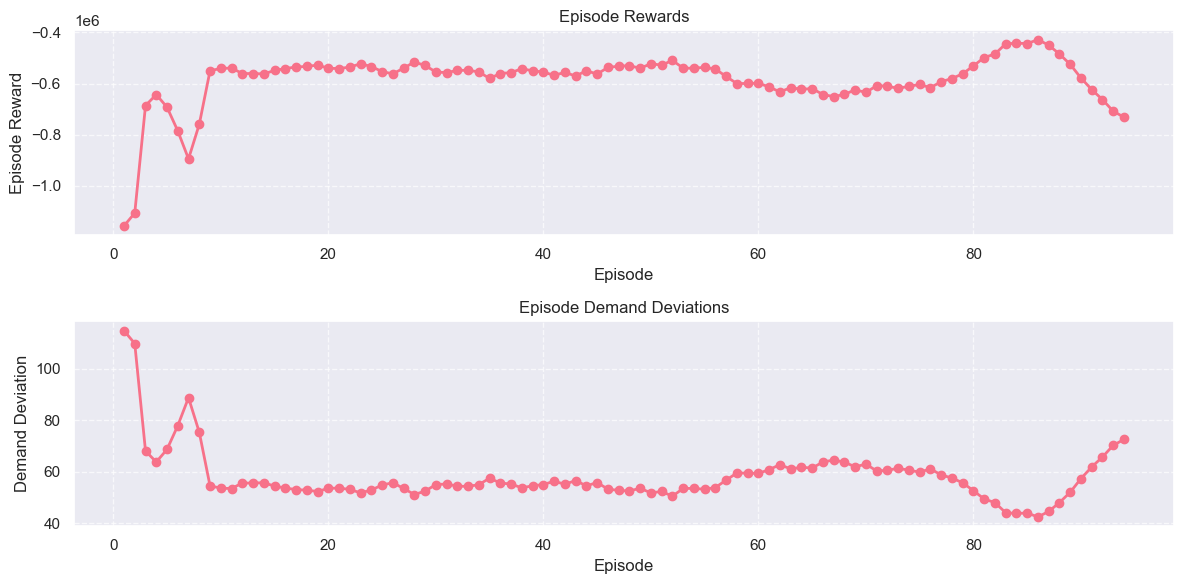

In [26]:
plot_rewards_and_deviations(rewards[:94], deviations[:94])

In [21]:
train_episodes = int(len(data_np_segments)*0.8)
test_episodes  = len(data_np_segments)-train_episodes

In [22]:
int(len(data_np_segments)*0.8)

94

Model actor_episode_5.h5 and critic_episode_5.h5: Average Reward = -546278.16 
Model actor_episode_10.h5 and critic_episode_10.h5: Average Reward = -543826.77 


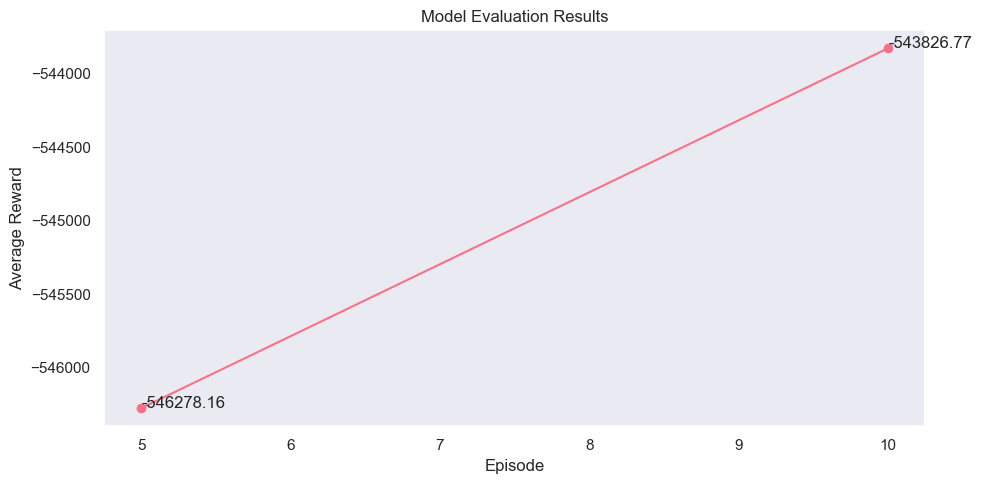

In [23]:
evaluate_saved_models(model_save_dir, train_episodes, test_episodes, window_length)